### 환경 초기화 및 하이퍼파라미터 설정

In [1]:
import gymnasium as gym 
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.distributions import Categorical 
import matplotlib.pyplot as plt 
from collections import deque 
import time 

# --- 하이퍼파라미터 설정 ---
LEARNING_RATE = 0.001 # Policy Network의 학습률
GAMMA = 0.99        # Discount Factor
MAX_EPISODES = 2000  # 학습을 진행할 총 에피소드 수
MAX_STEPS = 500     # 한 에피소드 내에서 최대로 진행할 스텝 수
PRINT_INTERVAL = 50  # 학습 중간 로그를 출력할 에피소드 간격

### Policy Network 정의

In [2]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim): 
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128) # input : state_dim, output : 128
        self.fc2 = nn.Linear(128, action_dim) # input : 128, output : action_dim

    def forward(self, x):
        x = F.relu(self.fc1(x)) # 첫 레이어 통과 후 ReLU activation function 적용
        action_probs = F.softmax(self.fc2(x), dim=-1) # 두 번째 레이어 통과 후 Softmax activation function 적용
        return action_probs

### Discounted Total Returns 계산 함수 정의

In [3]:
def calculate_discounted_returns(rewards, gamma):
    """ G_t = R_t + gamma * R_{t+1} + gamma^2 * R_{t+2} + ... """
    returns = [] # 각 타임스텝의 G_t를 저장할 리스트
    discounted_sum = 0 # Cumulative discounted sum
    for reward in reversed(rewards): # (R_T, R_{T-1}, ..., R_0) 역순으로 계산
        discounted_sum = reward + gamma * discounted_sum # G_t = R_t + gamma * G_{t+1}
        returns.insert(0, discounted_sum) # 계산된 G_t 값을 리스트의 맨 앞에 추가 > 원래 시간 순서대로 저장
    returns = torch.tensor(returns, dtype=torch.float32)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns # Normalized Total Return

### Training

In [4]:
env = gym.make('CartPole-v1') # CartPole-v1 환경 생성
state_dim = env.observation_space.shape[0] # cart position, cart velocity, pole angle, pole velocity
action_dim = env.action_space.n # left, right

policy_net = PolicyNetwork(state_dim, action_dim)
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

episode_rewards_history = [] # 에피소드별 Total Return을 저장할 리스트
recent_scores = deque(maxlen=100) # 최근 100개 에피소드 점수 양방향 큐에 저장 > 평균 점수 계산에 사용

print("학습 시작")
start_time = time.time()

for episode in range(MAX_EPISODES):
    state, _ = env.reset()
    log_probs = [] # 현재 에피소드에서 선택한 action의 로그 확률
    rewards = [] # 현재 에피소드에서 받은 Reward
    episode_reward = 0 # 현재 에피소드의 Total Return
    done = False # 에피소드 종료 여부 플래그
    truncated = False # 에피소드 시간초과 여부 플래그
    steps = 0 # 현재 에피소드에서 진행된 스텝 수

    # --- 에피소드 실행 루프 ---
    while not done and not truncated and steps < MAX_STEPS:
        state_tensor = torch.FloatTensor(state).unsqueeze(0) # 텐서로 변환 및 배치 차원 추가
        action_probs = policy_net(state_tensor)

        dist = Categorical(probs=action_probs) # 확률 분포 계산 위한 객체 생성
        action = dist.sample() # 분포에서 action 샘플링
        log_prob = dist.log_prob(action)# 샘플링된 action의 로그 확률 > Loss 계산에 사용

        next_state, reward, done, truncated, _ = env.step(action.item()) # 샘플링된 action 실행

        log_probs.append(log_prob) # 현재 에피소드에서 선택한 action의 로그 확률 저장
        rewards.append(reward) # 현재 에피소드에서 받은 Reward 저장
        episode_reward += reward # 현재 에피소드의 Total Return 업데이트
        state = next_state # state 업데이트
        steps += 1 # 스텝 수 업데이트

    # --- 에피소드 종료 후 결과 기록 ---
    episode_rewards_history.append(episode_reward) # 현재 에피소드의 Total Return을 히스토리에 추가
    recent_scores.append(episode_reward) # 현재 에피소드의 Total Return을 양방향 큐에 추가
    avg_score = np.mean(recent_scores) # 최근 100개 에피소드의 Averate Total Return

    # --- 에피소드 종료 후 Policy Network 업데이트 ---
    discounted_returns = calculate_discounted_returns(rewards, GAMMA) # 현재 에피소드의 스텝 별 Total Return으로 Discounted Total Return 계산

    policy_loss = []
    for log_prob_t, Gt in zip(log_probs, discounted_returns):
        policy_loss.append(-log_prob_t * Gt) # j(θ) =-G_t * log_prob(a_t|s_t;θ)

    optimizer.zero_grad()
    total_loss = torch.stack(policy_loss).sum() # 에피소드 내 모든 타임스텝의 Loss를 하나의 텐서를 묶고 모두 더함
    total_loss.backward()
    optimizer.step()

    # --- 주기적으로 학습 로그 출력 ---
    if episode % PRINT_INTERVAL == 0 and episode != 0:
        current_time = time.time() # 현재 시간 기록
        elapsed_time = current_time - start_time # 이전 로그 출력 시점부터 경과된 시간 계산
        print(f"에피소드: {episode}, 평균 점수(최근 100개): {avg_score:.2f}, 현재 점수: {episode_reward:.2f}, 걸린 시간: {elapsed_time:.2f}s")
        start_time = current_time # 다음 경과 시간 측정을 위해 시작 시간 업데이트

    # --- 학습 종료 조건 확인 ---
    if avg_score >= 475.0: # 종료 조건 : 최근 100개 에피소드 평균 점수 475.0 이상
        print(f"\n목표 달성! 에피소드 {episode}에서 해결. 최근 100개 평균 점수: {avg_score:.2f}")
        break # 학습 루프 종료


env.close() # 모든 에피소드 종료 또는 목표 달성 후 환경 종료
print("학습 종료.")

학습 시작
에피소드: 50, 평균 점수(최근 100개): 29.90, 현재 점수: 90.00, 걸린 시간: 4.90s
에피소드: 100, 평균 점수(최근 100개): 36.06, 현재 점수: 37.00, 걸린 시간: 2.46s
에피소드: 150, 평균 점수(최근 100개): 47.41, 현재 점수: 30.00, 걸린 시간: 3.13s
에피소드: 200, 평균 점수(최근 100개): 62.07, 현재 점수: 138.00, 걸린 시간: 4.51s
에피소드: 250, 평균 점수(최근 100개): 98.00, 현재 점수: 115.00, 걸린 시간: 7.20s
에피소드: 300, 평균 점수(최근 100개): 152.27, 현재 점수: 223.00, 걸린 시간: 10.39s
에피소드: 350, 평균 점수(최근 100개): 223.74, 현재 점수: 346.00, 걸린 시간: 17.05s
에피소드: 400, 평균 점수(최근 100개): 307.05, 현재 점수: 145.00, 걸린 시간: 20.38s
에피소드: 450, 평균 점수(최근 100개): 364.92, 현재 점수: 500.00, 걸린 시간: 25.34s
에피소드: 500, 평균 점수(최근 100개): 427.88, 현재 점수: 500.00, 걸린 시간: 29.71s
에피소드: 550, 평균 점수(최근 100개): 464.09, 현재 점수: 500.00, 걸린 시간: 30.03s
에피소드: 600, 평균 점수(최근 100개): 445.49, 현재 점수: 500.00, 걸린 시간: 30.42s
에피소드: 650, 평균 점수(최근 100개): 410.37, 현재 점수: 500.00, 걸린 시간: 24.75s
에피소드: 700, 평균 점수(최근 100개): 418.35, 현재 점수: 341.00, 걸린 시간: 26.63s
에피소드: 750, 평균 점수(최근 100개): 450.55, 현재 점수: 332.00, 걸린 시간: 28.20s
에피소드: 800, 평균 점수(최근 100개): 460.80, 현재 점수: 500.00

### 결과 시각화

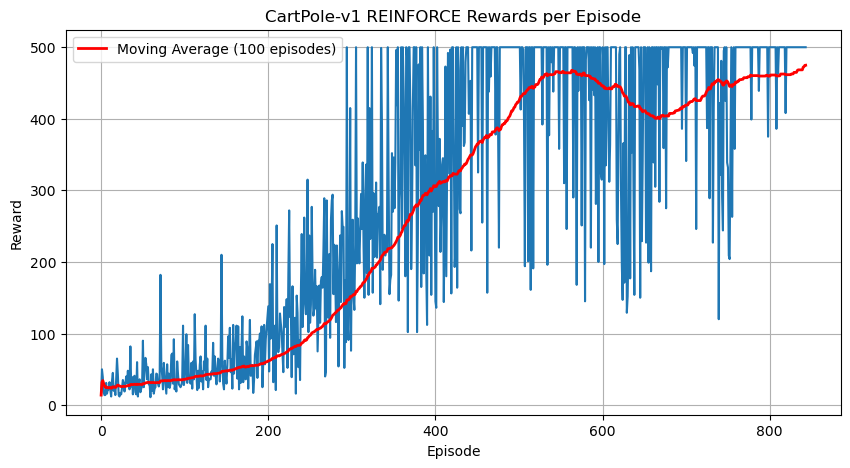

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards_history) # 에피소드별 Total Return 그래프 (파란색 선)

moving_avg = [np.mean(episode_rewards_history[max(0, i-100):i+1]) for i in range(len(episode_rewards_history))]
plt.plot(moving_avg, color='red', linewidth=2, label='Moving Average (100 episodes)') # 이동 평균선 그래프 (빨간색 선)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("CartPole-v1 REINFORCE Rewards per Episode")
plt.legend()
plt.grid(True)
plt.show()